In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Define the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])

#1. Data Collection and Pre-processing
# Load data (replace with your actual file names)
df = pd.read_csv('1. BASAL.csv')

# Creating a DataFrame from the numpy array #splitting the dataset
X = df.drop(columns=['SPAD'])  # Drop 'sample_id' and 'SPAD' to get the features
y = df['SPAD']  # Target variable

print(df)
print (X)
print(y )

# Check for missing values
print(df.isnull().sum())


      500.075    500.336    500.597    500.858    501.119    501.381  \
0    6.583333   7.472222   8.051111   7.846667   6.714444   6.973333   
1    6.281111   7.166667   7.824444   7.668889   6.552222   6.818889   
2    6.243333   7.154444   7.852222   7.733333   6.630000   6.917778   
3    7.586667   8.887778  10.127778  10.311111   9.137778   9.368889   
4    8.761111  10.051111  11.282222  11.428889  10.226667  10.410000   
..        ...        ...        ...        ...        ...        ...   
94   8.932222  10.238889  11.487778  11.673333  10.480000  10.673333   
95   7.494444   7.561111   7.492222   7.243333   6.858889   7.011111   
96   7.374444   7.472222   7.373333   7.021111   6.511111   6.628889   
97   6.687778   6.856667   6.797778   6.454444   5.890000   6.093333   
98  12.201111  13.646667  15.008889  15.252222  14.128889  14.355556   

      501.642    501.903    502.164    502.425  ...    948.856    949.094  \
0    7.746667   7.578889   6.730000   6.704444  ...  77.78

In [2]:
#Explore data statistics
df.describe()

500.075    500.336    500.597    500.858    501.119    501.381  \
count  99.000000  99.000000  99.000000  99.000000  99.000000  99.000000   
mean    6.358047   6.660348   6.906229   6.923614   6.589181   6.642817   
std     2.450184   2.587438   2.737231   2.717674   2.587619   2.671072   
min     2.690000   2.723333   2.723333   2.870000   2.720000   2.673333   
25%     3.975000   4.091667   4.348333   4.486667   4.210000   4.120000   
50%     6.325556   6.938889   7.076667   6.997778   6.502222   6.736667   
75%     8.207222   8.446667   8.456667   8.441667   8.450000   8.520000   
max    12.201111  13.646667  15.008889  15.252222  14.128889  14.355556   

         501.642    501.903    502.164    502.425  ...     948.856  \
count  99.000000  99.000000  99.000000  99.000000  ...   99.000000   
mean    6.932233   6.923793   6.655735   6.692088  ...   46.793199   
std     2.801769   2.776750   2.635493   2.576869  ...   21.649549   
min     2.893333   2.886667   2.660000   2.750000  ...   20.640000   
25%     4.400000   4.410000   4.200000   4.238333  ...   27.691667   
50%     6.927778   6.911111   6.540000   6.538889  ...   44.620000   
75%     8.616667   8.648333   8.606667   8.645000  ...   54.924444   
max    15.363333  15.263333  14.090000  13.826667  ...  106.491111   

          949.094     949.333     949.571     949.809     950.048     950.286  \
count   99.000000   99.000000   99.000000   99.000000   99.000000   99.000000   
mean    46.276801   46.420292   46.856846   46.594759   46.225432   46.272166   
std     21.733446   21.727518   21.625214   21.764859   21.886222   21.869000   
min     19.163333   19.550000   21.106667   20.760000   19.083333   19.643333   
25%     27.560000   27.478333   27.521667   27.203333   27.225000   27.180000   
50%     43.736667   43.910000   44.426667   44.073333   43.856667   44.016667   
75%     54.632222   54.692778   54.938333   54.817222   54.648333   54.706111   
max    106.148889  106.332222  106.667778  106.666667  106.353333  106.357778   

          950.524     950.763       SPAD  
count   99.000000   99.000000  99.000000  
mean    46.317149   45.945713  31.241313  
std     21.934898   22.072896   6.278641  
min     20.470000   18.496667  17.200000  
25%     26.671667   26.451667  26.650000  
50%     44.190000   44.123333  30.800000  
75%     54.753889   54.623333  37.500000  
max    106.508889  106.068889  42.200000  

[8 rows x 1783 columns]

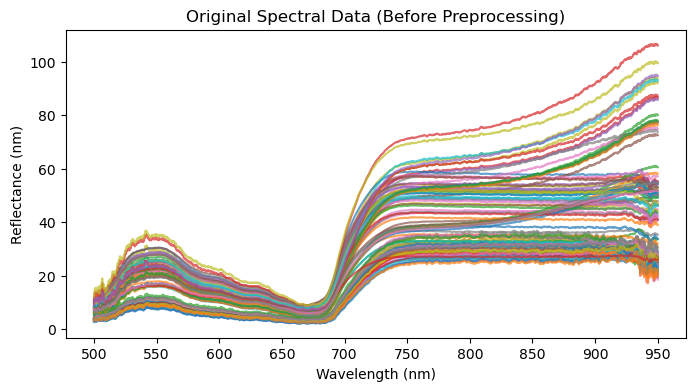

In [3]:
# Create the wavelength range from 500nm to 950nm
wavelengths = np.arange(500, 951, 50)  # Wavelengths from 500nm to 950nm with 100nm intervals
num_wavelengths = X.shape[1]  # Assuming the number of columns in X corresponds to the number of wavelengths

# Plot the spectral data
plt.figure(figsize=(8, 4))
plt.plot(X.T, alpha=0.7)

# Set x-axis labels to the wavelength values (500nm, 600nm, ..., 950nm)
plt.xticks(ticks=np.linspace(0, num_wavelengths-1, len(wavelengths)), labels=wavelengths)

# Add titles and labels
plt.title('Original Spectral Data (Before Preprocessing)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (nm)')

# Display the plot
plt.show()


In [4]:
# Step 1: Calculate Q1, Q3, and IQR for the spectral data
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Step 2: Identify outliers in the spectral data
outliers = (X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))

# Step 3: Create a mask to identify rows with any outliers
outlier_mask = outliers.any(axis=1)

# Step 4: Calculate the absolute deviation from the IQR boundaries for ranking
deviation = np.maximum((Q1 - X).abs(), (X - Q3).abs())

# Apply the mask to get deviations only for the identified outliers
deviation = deviation[outlier_mask]

# Step 5: Sum deviations across features for each sample (to rank overall extremeness)
total_deviation = deviation.sum(axis=1)

# Step 6: Calculate the maximum number of outliers to remove (5% of the total data)
num_samples = len(X)
max_outliers_to_remove = int(0.05 * num_samples)

# Get indices of the top 5% most extreme outliers
top_outlier_indices = total_deviation.nlargest(max_outliers_to_remove).index

# Create a new outlier mask based on the top 5% of deviations
final_outlier_mask = pd.Series(False, index=X.index)
final_outlier_mask.loc[top_outlier_indices] = True

# Step 7: Remove the top 5% most extreme outliers
cleaned_spectral_data = X[~final_outlier_mask]
cleaned_spad_data = y[~final_outlier_mask]

# Step 8: Combine the cleaned spectral data and SPAD values back into a single DataFrame (if needed)
cleaned_df = pd.concat([cleaned_spectral_data, cleaned_spad_data], axis=1)

# Step 9: Display the results
print(f"Original dataset size: {X.shape[0]}")
print(f"Number of outliers removed: {final_outlier_mask.sum()}")
print(f"Cleaned dataset size: {cleaned_df.shape[0]}")
print(f"Cleaned spectral data size: {cleaned_spectral_data.shape[0]}")

Original dataset size: 99
Number of outliers removed: 4
Cleaned dataset size: 95
Cleaned spectral data size: 95


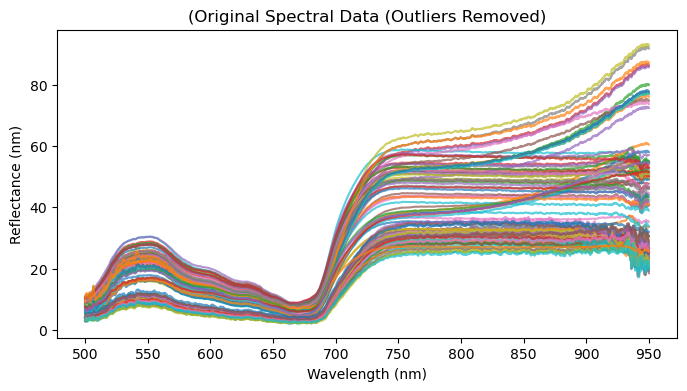

In [5]:
# Create the wavelength range from 500nm to 950nm
wavelengths = np.arange(500, 951, 50)  # Wavelengths from 500nm to 950nm with 100nm intervals
num_columns = cleaned_spectral_data.shape[1]


# Plot the spectral data
plt.figure(figsize=(8, 4))
plt.plot(cleaned_spectral_data.T, alpha=0.7)

# Set x-axis labels to the wavelength values (500nm, 600nm, ..., 950nm)
plt.xticks(ticks=np.linspace(0, num_wavelengths-1, len(wavelengths)), labels=wavelengths)

# Add titles and labels
plt.title('(Original Spectral Data (Outliers Removed)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (nm)')

# Display the plot
plt.show()

In [6]:
# Step 2: Calculate the correlation matrix for the combined DataFrame
correlation_matrix = cleaned_df.corr()

# Step 3: Extract correlations with the SPAD column (assuming the SPAD column is named 'SPAD')
correlations_with_spad = correlation_matrix['SPAD'].drop('SPAD')

# Step 4: Display the correlation values
print("Correlation values with SPAD:")
print(correlations_with_spad)

# Step 5: Sort correlations by absolute value to find strongest relationships
sorted_correlations = correlations_with_spad.abs().sort_values(ascending=False)
print("Top features correlated with SPAD:")
print(sorted_correlations.head(10))

# Step 6: Set a correlation threshold for feature selection
threshold = 0.5
mask = correlations_with_spad.abs() > threshold

# Step 7: Select features with a correlation higher than the threshold
selected_features = correlations_with_spad[mask].index
X_selected = cleaned_spectral_data[selected_features]


Correlation values with SPAD:
500.075   -0.814672
500.336   -0.777489
500.597   -0.722087
500.858   -0.699534
501.119   -0.739691
             ...   
949.809   -0.431776
950.048   -0.436707
950.286   -0.436658
950.524   -0.437425
950.763   -0.447558
Name: SPAD, Length: 1782, dtype: float64
Top features correlated with SPAD:
695.197    0.869574
695.451    0.869557
694.943    0.869090
695.706    0.868847
696.214    0.868222
694.688    0.868200
693.925    0.868135
696.468    0.868035
694.434    0.867964
693.671    0.867674
Name: SPAD, dtype: float64


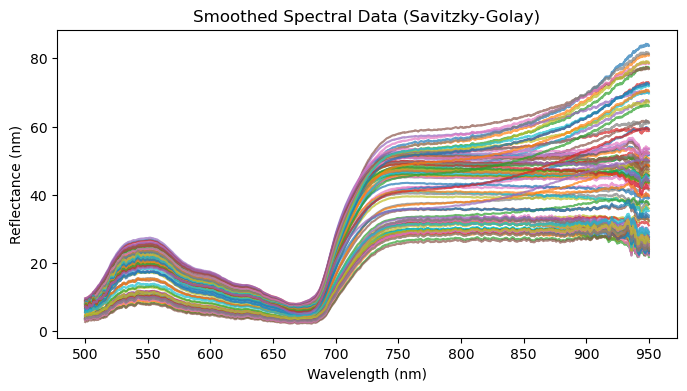

In [7]:
# Function to apply Savitzky-Golay smoothing
def savitzky_golay(cleaned_spectral_data, window_size=11, poly_order=2):
    return savgol_filter(cleaned_spectral_data, window_size, poly_order, axis=0)

# Apply Savitzky-Golay smoothing to X_selected
spectral_sgm = savitzky_golay(cleaned_spectral_data, window_size=11, poly_order=2)

# Create the wavelength range from 500nm to 950nm
wavelengths = np.arange(500, 951, 50)  # Wavelengths from 500nm to 950nm with 100nm intervals
num_columns = spectral_sgm.shape[1]


# Plot the spectral data
plt.figure(figsize=(8, 4))
plt.plot(spectral_sgm.T, alpha=0.7)

# Set x-axis labels to the wavelength values (500nm, 600nm, ..., 950nm)
plt.xticks(ticks=np.linspace(0, num_wavelengths-1, len(wavelengths)), labels=wavelengths)

# Add titles and labels
plt.title('Smoothed Spectral Data (Savitzky-Golay)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (nm)')

# Display the plot
plt.show()

Explained Variance Ratio: [9.36724049e-01 5.76923519e-02 4.67406157e-03 4.96683668e-04
 2.02329156e-04 8.93790109e-05 4.85812962e-05 3.18158939e-05
 8.19317929e-06 7.31967104e-06 6.51055032e-06 4.45709802e-06
 2.38590713e-06 2.14772977e-06 1.63092196e-06 1.47172037e-06
 1.39504020e-06 1.19981934e-06 9.16634799e-07 5.96865266e-07
 4.33870070e-07 3.04286085e-07 2.91155503e-07 1.91118987e-07
 1.66921207e-07 1.39421354e-07 1.06361974e-07 1.03973715e-07
 8.55639783e-08 7.92460569e-08 7.04001955e-08 4.44191958e-08
 4.16181119e-08 4.05146517e-08 3.52244725e-08 3.21313006e-08
 2.86458538e-08 2.48585942e-08 2.32809776e-08 2.24948862e-08
 1.98413518e-08 1.94972314e-08 1.85266335e-08 1.64284011e-08
 1.49242694e-08 1.40015766e-08 1.32074590e-08 1.22322547e-08
 1.03714983e-08 1.02153461e-08 9.36566170e-09 9.14583652e-09
 8.50794784e-09 7.64801287e-09 7.55832476e-09 7.15324354e-09
 6.23056156e-09 5.13949651e-09 4.99047689e-09 4.68931667e-09
 4.48381515e-09 3.63782814e-09 3.48005656e-09 3.13654034e-0

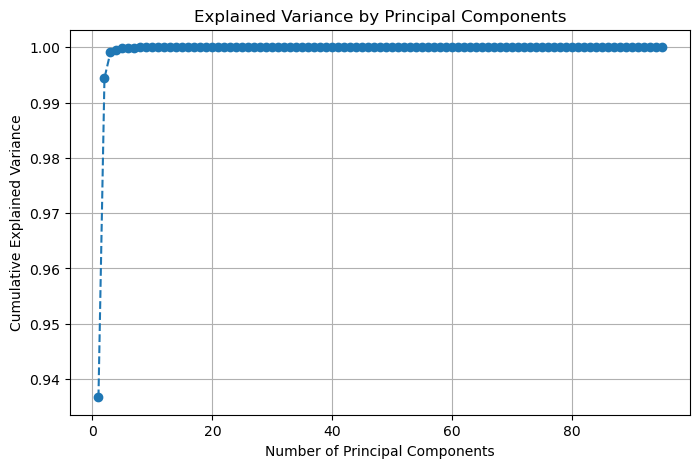

          PC1         PC2        PC3        PC4       PC5       PC6       PC7  \
0  614.178923  198.723666 -26.281960 -16.244266 -0.509502  0.538596  0.899269   
1  582.662417  169.865048 -15.512387 -11.189069 -0.329765 -0.470004  3.235113   
2  531.346255  143.414279  -6.805224  -7.065104  0.176428 -1.118336  4.949087   
3  460.230438  119.371359  -0.160470  -3.872371  1.009078 -1.406403  6.041191   
4  369.314965   97.736289   4.421874  -1.610869  2.168184 -1.334203  6.511424   

        PC8       PC9      PC10  ...      PC86      PC87      PC88  \
0  4.253794 -0.134722  0.325600  ... -0.000308  0.002443  0.005682   
1  2.059806  0.429043 -0.304655  ... -0.000003 -0.000902 -0.002387   
2  0.203935  0.831749 -0.767194  ...  0.000191 -0.002425 -0.005966   
3 -1.313819  1.073395 -1.062019  ...  0.000273 -0.002125 -0.005053   
4 -2.493455  1.153982 -1.189129  ...  0.000244 -0.000003  0.000349   

           PC89          PC90          PC91          PC92          PC93  \
0 -1.085806e-12 -

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# Step 2: Initialize and apply PCA
pca = PCA(n_components=None)  # Set to None to keep all components
pca_result = pca.fit_transform(spectral_sgm)

# Step 3: Analyze explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Step 4: Output results
print("Explained Variance Ratio:", explained_variance)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid()
plt.show()

# Step 5: Create a DataFrame with PCA results
pca_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])

# Display first few rows of PCA-transformed data
print(pca_df.head())

In [9]:
# 4. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_result,cleaned_spad_data, test_size=0.20, random_state=175)

In [10]:
# RFE (Recursive Feature Elimination) using RandomForestRegressor
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=20, step=25)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Print selected features and their rankings
selected_features = rfe.support_
feature_ranking = rfe.ranking_
print("Selected features (RFE):", selected_features)
print("Feature ranking (RFE):", feature_ranking)
# Display the selected features
print(f"Number of features selected by RFE: {len(selected_features)}")


Selected features (RFE): [ True  True  True False False False  True False False False False False
 False False False False False False  True False False  True False False
 False False False False False False  True False False  True False False
 False False False False False False False False False False False False
 False  True False False False False False False False False  True False
  True False False False  True False False False  True False  True  True
  True  True  True False  True False  True False False False False False
 False False False False False False False False False False False]
Feature ranking (RFE): [1 1 1 2 2 3 1 2 3 2 4 3 2 4 3 4 2 2 1 3 2 1 3 2 3 2 3 4 3 3 1 4 2 1 4 2 2
 4 4 2 3 4 3 2 4 2 3 2 4 1 3 4 2 3 3 4 3 2 1 2 1 4 3 2 1 3 2 3 1 2 1 1 1 1
 1 2 1 3 1 2 3 3 3 4 4 4 3 4 4 4 4 4 4 4 4]
Number of features selected by RFE: 95


In [11]:
from scipy.stats import pearsonr

# Function to calculate vegetation indices
def calculate_indices(X_train_rfe, wavelengths):
    """
    Calculate various vegetation indices based on spectral data.

    Parameters:
    spectral_sgm: numpy array (samples x wavelengths)
    wavelengths: numpy array of corresponding wavelengths (same length as spectral_sgm columns)

    Returns:
    indices_df: DataFrame of calculated indices
    """
    # Define wavelength ranges for each band
    green_band = np.mean(spectral_sgm[:, (wavelengths >= 500) & (wavelengths <= 600)], axis=1)
    red_band = np.mean(spectral_sgm[:, (wavelengths >= 600) & (wavelengths <= 700)], axis=1)
    nir_band = np.mean(spectral_sgm[:, (wavelengths >= 750) & (wavelengths <= 950)], axis=1)
    red_edge_band = np.mean(spectral_sgm[:, (wavelengths >= 700) & (wavelengths <= 750)], axis=1)

    # Calculate vegetation indices
    ndvi = (nir_band - red_band) / (nir_band + red_band)
    savi = 1.5 * (nir_band - red_band) / (nir_band + red_band + 0.5)
    msavi = (2 * nir_band + 1 - np.sqrt((2 * nir_band + 1)**2 - 8 * (nir_band - red_band))) / 2
    gndvi = (nir_band - green_band) / (nir_band + green_band)
    rvi = nir_band / red_band
    tvi = 0.5 * (120 * (nir_band - green_band) - 200 * (red_band - green_band))
    rdvi = (nir_band - red_band) / np.sqrt(nir_band + red_band)
    osavi = (nir_band - red_band) / (nir_band + red_band + 0.16)
    sr = nir_band / red_band
    mtvi = 1.5 * ((1.2 * (nir_band - green_band)) - (2.5 * (red_band - green_band)))
    cigreen = (nir_band / green_band) - 1
    msr = (nir_band / red_band - 1) / np.sqrt(nir_band / red_band + 1)
    cire = (nir_band / red_edge_band) - 1
    rev = red_edge_band / nir_band

    # Store all indices in a DataFrame
    indices_df = pd.DataFrame({
        "R": red_band,
        "G": green_band,
        "NIR": nir_band,
        "RedEdge": red_edge_band,
        "NDVI": ndvi,
        "SAVI": savi,
        "MSAVI": msavi,
        "GNDVI": gndvi,
        "RVI": rvi,
        "TVI": tvi,
        "RDVI": rdvi,
        "OSAVI": osavi,
        "SR": sr,
        "MTVI": mtvi,
        "CIgreen": cigreen,
        "MSR": msr,
        "CIre": cire,
        "REV": rev
    })
    return indices_df

# Function to calculate correlation coefficients
def calculate_correlations(indices_df, cleaned_spad_data):
    """
    Calculate correlation coefficients between vegetation indices and cleaned SPAD data.

    Parameters:
    indices_df: DataFrame of vegetation indices
    cleaned_spad_data: numpy array of SPAD values

    Returns:
    correlation_df: DataFrame of correlation coefficients and p-values
    """
    correlations = []
    for index_name in indices_df.columns:
        corr, p_value = pearsonr(indices_df[index_name], cleaned_spad_data)
        correlations.append({"Index": index_name, "Correlation": corr, "P-Value": p_value})
    
    correlation_df = pd.DataFrame(correlations)
    return correlation_df

# Define wavelengths to match the number of columns in spectral_sgm
num_wavelengths = spectral_sgm.shape[1]
wavelengths = np.linspace(500, 950, num_wavelengths)  # Define wavelengths

# Step 1: Calculate vegetation indices
indices_df = calculate_indices(spectral_sgm, wavelengths)

# Step 2: Calculate correlations
cleaned_spad_data = np.array(cleaned_spad_data)  # Assuming SPAD values are in a numpy array
correlation_df = calculate_correlations(indices_df, cleaned_spad_data)

# Step 3: Filter significant correlations
significant_correlations = correlation_df[correlation_df["P-Value"] < 0.05]

# Output results
print("All Correlations:")
print(correlation_df)
print("\nSignificant Correlations:")
print(significant_correlations)

All Correlations:
      Index  Correlation       P-Value
0         R    -0.854203  3.689435e-28
1         G    -0.854876  3.023561e-28
2       NIR    -0.637268  3.828851e-12
3   RedEdge    -0.798447  3.300635e-22
4      NDVI     0.760484  3.918361e-19
5      SAVI     0.745317  4.642504e-18
6     MSAVI     0.754767  1.016097e-18
7     GNDVI     0.773463  4.066913e-20
8       RVI     0.754081  1.137300e-18
9       TVI    -0.581996  6.180481e-10
10     RDVI    -0.350717  4.930935e-04
11    OSAVI     0.755779  8.601229e-19
12       SR     0.754081  1.137300e-18
13     MTVI    -0.609992  5.321438e-11
14  CIgreen     0.769330  8.501385e-20
15      MSR     0.758229  5.724049e-19
16     CIre     0.393377  8.025388e-05
17      REV    -0.438039  9.019321e-06

Significant Correlations:
      Index  Correlation       P-Value
0         R    -0.854203  3.689435e-28
1         G    -0.854876  3.023561e-28
2       NIR    -0.637268  3.828851e-12
3   RedEdge    -0.798447  3.300635e-22
4      NDVI     0.7

In [42]:
# Define parameter grids for RandomizedSearchCV
# Parameter grid for RandomizedSearchCV
n_estimators = np.arange(5, 100, 8)
max_depth = np.arange(5, 50, 3)
min_samples_split = np.arange(4, 60, 5)
min_samples_leaf = np.arange(4, 50,5)
min_impurity_decrease = np.linspace(0, 0.1, 2)
# Adding max_features and min_impurity_decrease to help control complexity
param_dist_rf = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'min_impurity_decrease': min_impurity_decrease,  # Helps reduce overfitting
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2']
   
}
# Initialize models
model_rf = RandomForestRegressor(random_state=175)

# Perform RandomizedSearchCV for each model
random_search_rf = RandomizedSearchCV(model_rf, param_distributions=param_dist_rf, n_iter=175, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_rf.fit(X_train_rfe, y_train)
best_rf = random_search_rf.best_estimator_
best_params_rf = random_search_rf.best_params_
print("Best parameters for Random Forest: ", best_params_rf)
# Cross-validation with the best hyperparameters for each model
mse_scores_rf = cross_val_score(best_rf, X_train_rfe, y_train, scoring='neg_mean_squared_error', cv=5)
# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_rf = -mse_scores_rf
average_mse_rf = np.mean(mse_scores_rf)

# Print cross-validation results
print(f"Average MSE for Random Forest: {average_mse_rf}")

# Evaluate the individual models
models = {
    "RandomForest": best_rf
}

# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_rfe, y_train)
    
    y_train_pred = model.predict(X_train_rfe)
    y_test_pred = model.predict(X_test_rfe)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)


Best parameters for Random Forest:  {'n_estimators': 53, 'min_samples_split': 34, 'min_samples_leaf': 9, 'min_impurity_decrease': 0.1, 'max_features': 'auto', 'max_depth': 14, 'bootstrap': False}
Average MSE for Random Forest: 8.493881960135084
Evaluating RandomForest model...
Training Metrics:
                  MAE       MSE   Pearson        R2      RMSE       RPD
RandomForest  1.75636  5.179815  0.931732  0.868124  2.275921  2.753704

Testing Metrics:
                   MAE       MSE   Pearson        R2      RMSE       RPD
RandomForest  1.799967  5.568023  0.947111  0.877185  2.359666  2.853475


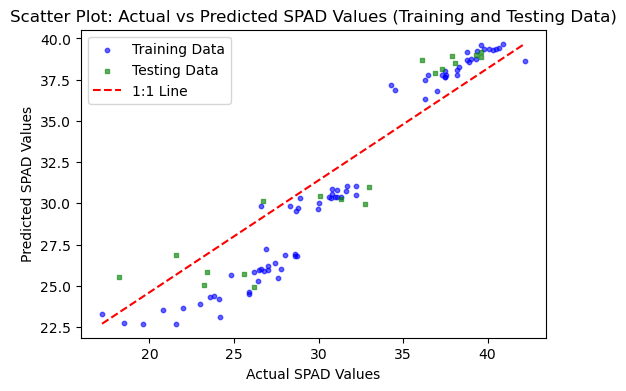

In [13]:
import matplotlib.pyplot as plt

# Assuming these are your actual and predicted SPAD values for both training and testing sets
y_train_actual = y_train # Replace with your actual training SPAD values
y_train_predicted = y_train_pred # Replace with your predicted SPAD values from the model (training)

y_test_actual = y_test  # Replace with your actual testing SPAD values
y_test_predicted = y_test_pred  # Replace with your predicted SPAD values from the model (testing)

# Combined Plot
plt.figure(figsize=(6, 4))

# Scatter plot for Training Data (circles)
plt.scatter(y_train_actual, y_train_predicted, color='blue', alpha=0.6, s=10, marker='o', label='Training Data')

# Scatter plot for Testing Data (squares)
plt.scatter(y_test_actual, y_test_predicted, color='green', alpha=0.6, s=10, marker='s', label='Testing Data')

# Plot the 1:1 line (perfect prediction)
plt.plot([min(min(y_train_actual), min(y_test_actual)), max(max(y_train_actual), max(y_test_actual))],
         [min(min(y_train_predicted), min(y_test_predicted)), max(max(y_train_predicted), max(y_test_predicted))],
         color='red', linestyle='--', label='1:1 Line')

# Labels and title
plt.xlabel('Actual SPAD Values', fontsize=10)
plt.ylabel('Predicted SPAD Values', fontsize=10)
plt.title('Scatter Plot: Actual vs Predicted SPAD Values (Training and Testing Data)', fontsize=12)

# Add legend
plt.legend()

# Remove grid and display plot
plt.show()



In [37]:
# Define parameter grids for RandomizedSearchCV
n_estimators = np.arange(2, 50,4)
learning_rate = np.arange(0.1, 1, 0.2)
max_depth = np.arange(2, 50, 3)
subsample = np.arange(0.9, 1.0, 0.5) 
colsample_bytree = np.arange(0.5, 1.0, 0.5)

# Additional hyperparameters to help control model complexity
gamma = np.arange(0, 0.5, 0.05)  # Regularization term to reduce overfitting
reg_lambda = np.arange(0.6, 1.0, 0.6)  # L2 regularization
reg_alpha = np.arange(0.5, 1.0, 0.6)  # L1 regularization

param_dist_xgb = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'max_depth': max_depth,
    'subsample': subsample,
    'colsample_bytree': colsample_bytree,
    'gamma': gamma,  # Regularization parameters
    'reg_lambda': reg_lambda,
    'reg_alpha': reg_alpha
}
# Initialize models
model_xgb = XGBRegressor(objective='reg:squarederror', random_state=175)
# Perform RandomizedSearchCV for each model
random_search_xgb = RandomizedSearchCV(model_xgb, param_distributions=param_dist_xgb, n_iter=175, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_xgb.fit(X_train_rfe, y_train)
best_xgb = random_search_xgb.best_estimator_
best_params_xgb = random_search_xgb.best_params_
print("Best parameters for XGBoost: ", best_params_xgb)
# Cross-validation with the best hyperparameters for each model
mse_scores_xgb = cross_val_score(best_xgb, X_train_rfe, y_train, scoring='neg_mean_squared_error', cv=5)
# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_xgb = -mse_scores_xgb
average_mse_xgb = np.mean(mse_scores_xgb)
# Print cross-validation results
print(f"Average MSE for XGBoost: {average_mse_xgb}")


# Evaluate the individual models
models = {
      "XGBoost": best_xgb
}

# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_rfe, y_train)
    
    y_train_pred = model.predict(X_train_rfe)
    y_test_pred = model.predict(X_test_rfe)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)


Best parameters for XGBoost:  {'subsample': 0.9, 'reg_lambda': 0.6, 'reg_alpha': 0.5, 'n_estimators': 34, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.05, 'colsample_bytree': 0.5}
Average MSE for XGBoost: 9.34885791872067
Evaluating XGBoost model...
Training Metrics:
              MAE       MSE   Pearson        R2      RMSE       RPD
XGBoost  1.053198  1.784587  0.982137  0.954565  1.335884  4.691433

Testing Metrics:
              MAE        MSE   Pearson        R2      RMSE       RPD
XGBoost  2.539896  10.949411  0.908802  0.758486  3.308989  2.034835


In [31]:
# Define parameter grids for RandomizedSearchCV
n_estimators = np.arange(2,80,2)
learning_rate = np.arange(0.01, 1, 0.09)
max_depth = np.arange(2, 40,3)

param_dist_gb = {
   'n_estimators': n_estimators,
   'learning_rate': learning_rate,
   'max_depth': max_depth
}

# Initialize models
model_gb = GradientBoostingRegressor(random_state=175)

# Perform RandomizedSearchCV for each model
random_search_gb = RandomizedSearchCV(model_gb, param_distributions=param_dist_gb, n_iter=48, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_gb.fit(X_train_rfe, y_train)
best_gb = random_search_gb.best_estimator_
best_params_gb = random_search_gb.best_params_
print("Best parameters for Gradient Boosting: ", best_params_gb)
# Cross-validation with the best hyperparameters for each model
mse_scores_gb = cross_val_score(best_gb, X_train_rfe, y_train, scoring='neg_mean_squared_error', cv=5)

# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_gb = -mse_scores_gb
average_mse_gb = np.mean(mse_scores_gb)
# Print cross-validation results
print(f"Average MSE for Gradient Boosting: {average_mse_gb}")
# Evaluate the individual models
models = {
    "GradientBoosting": best_gb
    }
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_rfe, y_train)
    
    y_train_pred = model.predict(X_train_rfe)
    y_test_pred = model.predict(X_test_rfe)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)


Best parameters for Gradient Boosting:  {'n_estimators': 8, 'max_depth': 2, 'learning_rate': 0.37}
Average MSE for Gradient Boosting: 7.939304088081338
Evaluating GradientBoosting model...
Training Metrics:
                       MAE       MSE   Pearson        R2      RMSE       RPD
GradientBoosting  0.930154  1.367453  0.985505  0.965185  1.169381  5.359425

Testing Metrics:
                       MAE       MSE   Pearson        R2      RMSE       RPD
GradientBoosting  1.986596  8.409195  0.927983  0.814517  2.899861  2.321921


In [30]:
# Define parameter grids for RandomizedSearchCV
C = np.arange(0.2, 8, 0.7)
epsilon = np.arange(1, 80, 2)

param_dist_svr = {
    'C': C,
    'epsilon': epsilon,
    'kernel': ['linear', 'rbf']
}
# Initialize models
model_svr = SVR()
# Perform RandomizedSearchCV for each model
random_search_svr = RandomizedSearchCV(model_svr, param_distributions=param_dist_svr, n_iter=150, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_svr.fit(X_train_rfe, y_train)
best_svr = random_search_svr.best_estimator_
best_params_svr = random_search_svr.best_params_
print("Best parameters for SVR: ", best_params_svr)
# Cross-validation with the best hyperparameters for each model
mse_scores_svr = cross_val_score(best_svr, X_train_rfe, y_train, scoring='neg_mean_squared_error', cv=5)

# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_svr = -mse_scores_svr
average_mse_svr = np.mean(mse_scores_svr)
# Print cross-validation results
print(f"Average MSE for SVR: {average_mse_svr}")
# Evaluate the individual models
models = {
    "SVR": best_svr
}
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_rfe, y_train)
    
    y_train_pred = model.predict(X_train_rfe)
    y_test_pred = model.predict(X_test_rfe)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)

Best parameters for SVR:  {'kernel': 'rbf', 'epsilon': 1, 'C': 1.5999999999999999}
Average MSE for SVR: 8.560251672901114
Evaluating SVR model...
Training Metrics:
          MAE      MSE   Pearson        R2     RMSE       RPD
SVR  1.885197  7.29632  0.909539  0.814239  2.70117  2.320184

Testing Metrics:
          MAE        MSE   Pearson        R2      RMSE       RPD
SVR  2.308053  11.517144  0.918375  0.745964  3.393692  1.984048


In [29]:
# Define parameter grids for RandomizedSearchCV
alpha = np.logspace(-1, 80, 1)  # Range from 0.001 to 100
l1_ratio = np.linspace(0.1, 1, 100)  # More granular search for l1 ratio

param_dist_elnet = {
    'alpha': alpha,
    'l1_ratio': l1_ratio
}
# Initialize models
model_elnet = ElasticNet(random_state=175) 
# Perform RandomizedSearchCV for each model
random_search_elnet = RandomizedSearchCV(model_elnet, param_distributions=param_dist_elnet, n_iter=25, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_elnet.fit(X_train_rfe, y_train)
best_elnet = random_search_elnet.best_estimator_
best_params_elnet = random_search_elnet.best_params_
print("Best parameters for Elastic Net: ", best_params_elnet)
# Cross-validation with the best hyperparameters for each model
mse_scores_elnet = cross_val_score(best_elnet, X_train_rfe, y_train, scoring='neg_mean_squared_error', cv=5)

# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_elnet = -mse_scores_elnet
average_mse_elnet = np.mean(mse_scores_elnet)
# Print cross-validation results
print(f"Average MSE for Elastic Net: {average_mse_elnet}")
# Evaluate the individual models
models = {
    "ElasticNet": best_elnet
}
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_rfe, y_train)
    
    y_train_pred = model.predict(X_train_rfe)
    y_test_pred = model.predict(X_test_rfe)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)

Best parameters for Elastic Net:  {'l1_ratio': 0.1, 'alpha': 0.1}
Average MSE for Elastic Net: 8.97046959552272
Evaluating ElasticNet model...
Training Metrics:
                MAE       MSE   Pearson        R2      RMSE       RPD
ElasticNet  2.13505  7.836625  0.894734  0.800483  2.799397  2.238772

Testing Metrics:
                 MAE      MSE   Pearson        R2      RMSE       RPD
ElasticNet  2.960212  15.5294  0.834081  0.657465  3.940736  1.708627


In [18]:
# Define parameter grids for RandomizedSearchCV

# Initialize models
model_plsr = PLSRegression(n_components=2) 

# Perform RandomizedSearchCV for each model
# PLSR does not require hyperparameter tuning here
best_plsr = model_plsr
best_plsr.fit(X_train_rfe, y_train)
# Cross-validation with the best hyperparameters for each model

mse_scores_plsr = cross_val_score(best_plsr, X_train_rfe, y_train, scoring='neg_mean_squared_error', cv=5)
# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_plsr = -mse_scores_plsr
average_mse_plsr = np.mean(mse_scores_plsr)
# Print cross-validation results
print(f"Average MSE for PLSR: {average_mse_plsr}")
# Evaluate the individual models
models = {
    "PLSR": best_plsr
}
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_rfe, y_train)
    
    y_train_pred = model.predict(X_train_rfe)
    y_test_pred = model.predict(X_test_rfe)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)

Average MSE for PLSR: 9.350794654732935
Evaluating PLSR model...
Training Metrics:
           MAE       MSE   Pearson        R2      RMSE       RPD
PLSR  1.647395  4.671264  0.938654  0.881072  2.161311  2.899728

Testing Metrics:
           MAE        MSE   Pearson        R2      RMSE       RPD
PLSR  3.111764  17.629186  0.811459  0.611149  4.198712  1.603646


In [19]:
# Ensemble the models using Voting Regressor
ensemble_model = VotingRegressor(estimators=[
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('gb', best_gb),
    ('svr', best_svr),
    ('elnet', best_elnet)
])

ensemble_model.fit(X_train_rfe, y_train)
y_ensemble_pred = ensemble_model.predict(X_test_rfe)

# Evaluate the ensemble model
ensemble_metrics_train = calculate_metrics(y_train, ensemble_model.predict(X_train_rfe))
ensemble_metrics_test = calculate_metrics(y_test, y_ensemble_pred)
print("\nEnsemble Model Training Metrics:")
print(pd.DataFrame(ensemble_metrics_train, index=["Ensemble"]).T)
print("\nEnsemble Model Testing Metrics:")
print(pd.DataFrame(ensemble_metrics_test, index=["Ensemble"]).T)


Ensemble Model Training Metrics:
         Ensemble
MSE      1.322924
RMSE     1.150184
MAE      0.825458
R2       0.966319
RPD      5.448877
Pearson  0.985066

Ensemble Model Testing Metrics:
         Ensemble
MSE      9.152990
RMSE     3.025391
MAE      2.016242
R2       0.798110
RPD      2.225579
Pearson  0.920549


In [20]:
# Ensemble the models using Voting Regressor # 2 the best model ensembled
ensemble_model = VotingRegressor(estimators=[
    ('rf', best_rf),
    ('xgb', best_xgb)
])

ensemble_model.fit(X_train_rfe, y_train)
y_ensemble_pred = ensemble_model.predict(X_test_rfe)

# Evaluate the ensemble model
ensemble_metrics_train = calculate_metrics(y_train, ensemble_model.predict(X_train_rfe))
ensemble_metrics_test = calculate_metrics(y_test, y_ensemble_pred)
print("\nEnsemble Model Training Metrics:")
print(pd.DataFrame(ensemble_metrics_train, index=["Ensemble"]).T)
print("\nEnsemble Model Testing Metrics:")
print(pd.DataFrame(ensemble_metrics_test, index=["Ensemble"]).T)


Ensemble Model Training Metrics:
         Ensemble
MSE      0.713462
RMSE     0.844667
MAE      0.607496
R2       0.981836
RPD      7.419744
Pearson  0.991705

Ensemble Model Testing Metrics:
         Ensemble
MSE      8.480593
RMSE     2.912146
MAE      2.083591
R2       0.812942
RPD      2.312126
Pearson  0.929962
